# Interpolators with "decay" in HARK

## Preliminaries

Suppose we have an interpolator $f(\cdot):\mathbb{R}^n\rightarrow \mathbb{R}$ that is set up over a cartesian grid. Denote the greatest points of the i-th dimension grid with $\bar{x}_i$. Suppose we have some limiting function $g(\cdot): \mathbb{R}^n\rightarrow \mathbb{R}$ and we want to construct some enhanced function $h(\cdot):\mathbb{R}^n\rightarrow \mathbb{R}$ such that:
- $h(x) = f(x)$ when $x$ falls inside of the limits of $f$'s grids, that is $x_i \leq \bar{x}_i$ $\forall i=1,...,n$.
- $h(x)\rightarrow g(x)$ when $x\rightarrow\infty$ in any of its dimensions.

We might want to construct such functions if we are worried about the performance of our interpolator $f(\cdot)$ when approximating values that fall far-off its grid. As demonstrated in Section 5.10 of ["Solution Methods for Microeconomic Dynamic Stochastic Optimization Problems"](https://llorracc.github.io/SolvingMicroDSOPs/) this situation arises when approximating the solution of consumption-saving problems: extrapolated solutions can have characteristics that are at odds with the basic theoretical properties of our problems. Fortunately, it is often possible to analytically solve the limiting version of these problems---for instance a version of a consumption-saving problem where wealth is infinitely larger than income---and to use these analytical solutions $g(\cdot)$ to moderate the extrapolating behavior of our numerical solutions.

This notebook exemplifies the use of HARK's `econforgeinterp.DecayInterp` class, which implements n-dimensional interpolators that assymptotically approach a given analytical function off their grids.

In [15]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from HARK.econforgeinterp import LinearFast, DecayInterp
from HARK.interpolation import LinearInterp

## Basic use of the `DecayInterp` class

`DecayInterp` requires two basic inputs:
- `interp`, which is the interpolator $f(\cdot)$. It must be an instance of the `HARK.econforgeinterp.LinearFast` class.
- `limit_fun`, which is the limiting function $g(\cdot)$. It must receive the same number of inputs as `interp` and be able to take `numpy` arrays as inputs.

And that's it! 

### An example with a 2D function

Imagine an "$h(\cdot)$" type of function of two dimensions for which:
- $f(x,y) = 2*x + y$.
- $g(x,y) = \sqrt{x} + \sin(y)$.
The following cell creates a `DecayInterp` object representing such function.

In [16]:
# Construct the interpolator

# Grids
x_grid = np.linspace(0, 10, 11)
y_grid = np.linspace(0, 10, 11)
x, y = np.meshgrid(x_grid, y_grid, indexing="ij")
# Function value
z = 2 * x + y
# Create interpolator
interp = LinearFast(z, [x_grid, y_grid])

# Limit function
lim_fun = lambda x, y: np.sqrt(x) - np.sin(y)

# Construct the interpolator with decay extrapolation (h function)
my_decay_interp = DecayInterp(
    interp = interp,
    limit_fun= lim_fun,
)

The following cell plots the function.

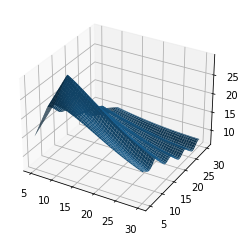

In [17]:
# Create some points to evaluate the function
x_ev, y_ev = np.meshgrid(
    np.linspace(5, 30, 100),
    np.linspace(5, 30, 100),
    indexing="ij",
)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_ev, y_ev, my_decay_interp(x_ev, y_ev))
plt.show()

Notice that the cell above defined $10$ as the greatest gridpoint in both dimensions $x$ and $y$. Therrefore, our plot should look like $2*x + y$ in the square $[0,10]^2$, and drift towards $\sqrt{x} + \sin(y)$ continuously when $x > 10$ or $y > 10$.

This is indeed the case, but there is a 'kink' that occurs along the $x=10$ and $y=10$ lines: the change in the behavior of the function is abrupt, and we might not want that depending on our application. If we want to avoid this sort of behavior, or control what happens in points that are outside the interpolator's grid but close to it, we have to tinker with the way in which we combine the $f(\cdot)$ and $g(\cdot)$ functions. `DecayInterp` refers to the way in which it combines the functions as its `decay_method`.

The class currently has three different decay methods:
- "`decay_prop`", the default.
- "`decay_hark`", which matches `HARK.interpolation.LinearInterp`'s decay method in the 1D case.
- "`paste`".

We now explain each method.

## `decay_method==decay_prop`

## `decay_method==decay_hark`

For any $x\in \mathbb{R}^n$ denote with $\bar{x}$ the closest point to $x$ which falls inside of $f's$ grid.

## Decay

For $x$ inside the grid we will just use $f(x)$. Now consider $x$'s such that $x \geq \bar{x}$.

We want to take an $h$ of the following form
\begin{equation}
    h(x) = g(x) - \left[g\left(\bar{x}\right) - f\left(\bar{x}\right)\right]\times\exp\{-B(x)\cdot(x - \bar{x})\}
\end{equation}

The weights $B(x)$ control how fast $h(\cdot)$ converges to $g(\cdot)$.

### Weights

Consider the weights
\begin{equation*}
B(x) = -\frac{1}{g\left(\bar{x}\right) - f\left(\bar{x}\right)}\times \left[ \nabla g\left(\bar{x}\right) - \nabla f\left(\bar{x}\right)\right].
\end{equation*}

They make $h(x)$ approach $g(x)$ faster when:
- $f$ and $g$ were close at the edge of the grid to begin with.
- $f$ and $g$ 's slopes suggest that they were approaching rapidly at the edge of the grid.

## `decay_method==paste`

## Comparing `econforge.DecayInterp` with `interpolation.LinearInterp`

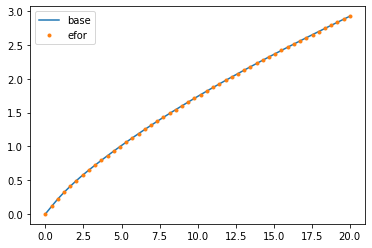

In [18]:
# Compare with base HARK
lim_slope = 0.1
lim_inter = 1.0

# Irregular grid
x = np.sqrt(np.linspace(0, 10, 20))
y = lim_inter + lim_slope * x - 1 / (0.2 * x + 1)

# Hark's base implementation
base_lim_interp = LinearInterp(
    x, y, intercept_limit=lim_inter, slope_limit=lim_slope
)

# New implementation
efor_lim_interp = DecayInterp(
    LinearFast(y, [x]),
    limit_fun=lambda x: lim_inter + lim_slope * x,
    limit_grad=lambda x: [lim_slope * np.ones_like(x)],
    extrap_method="decay_hark",    
)

# Evaluate them
x_eval = np.linspace(0, 20, 50)
base_vals = base_lim_interp(x_eval)
efor_vals = efor_lim_interp(x_eval)

# Plot and compare
plt.figure()
plt.plot(x_eval, base_vals, label="base")
plt.plot(x_eval, efor_vals, '.', label="efor")
plt.legend()
plt.show()

## An ilustration of the different "decay methods"

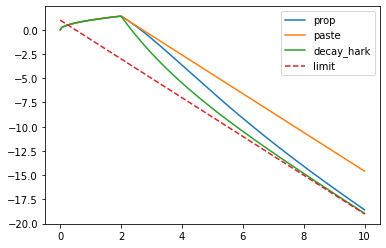

In [19]:
# Compare decay methods

x = np.linspace(0, 2, 50)
interp = LinearFast(np.sqrt(x), [x])
limit_fun = lambda x: 1 + -2 * x
limit_grad = lambda x: [-2 * np.ones_like(x)]

dec_pr = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="decay_prop",    
)

dec_pa = DecayInterp(
    interp, limit_fun=limit_fun, limit_grad=limit_grad, extrap_method="paste",
)

dec_ha = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="decay_hark",   
)

x_ev = np.linspace(0, 10, 200)

plt.figure()
plt.plot(x_ev, dec_pr(x_ev), label="prop")
plt.plot(x_ev, dec_pa(x_ev), label="paste")
plt.plot(x_ev, dec_ha(x_ev), label="decay_hark")
plt.plot(x_ev, limit_fun(x_ev), "--", label="limit")
plt.legend()
plt.show()